# Calibration of the Sr/Ca paleothermometer: A Bayesian approach

## Authors

[Deborah Khider](https://orcid.org/0000-0001-7501-8430)

## Preamble
 In the [previous notebook](Calibration.ipynb), we performed the regression using least square regression. This notebook approaches the same task using Bayesian statistics, for which a good introduction is given [here](https://seeing-theory.brown.edu/bayesian-inference/index.html#section2). 

The goal of Bayesian linear regression is the same as its frequentist counterpart, which is to infer the parameters of the regression equation (i.e., the slope and intercept) that best fits the data. The main difference between the two is that Bayesian regression tries to infer the (posterior) distribution of the parameters, given some _a priori_ notions and the data. This is in contrast to the frequentist approach, which makes often strong assumptions so it can derive best estimates for these parameters, occasionally with a measure of uncertainty, using only the data.  A good introduction on Bayesian Linear Regression is available in this [Medium blog post](https://medium.com/intuition/gentle-introduction-of-bayesian-linear-regression-c83da6b0d1f7).


To perform the regression on the coral data from Delong et al. (2011), we will be using the [PyMC package](https://www.pymc.io/welcome.html#sponsors). The following is adapted from the [example provided with package](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html#glm-linear). 

Let's also import some necessary packages along with PyMC:

In [54]:
#Some config magic first
import pytensor
pytensor.config.mode='NUMBA'
pytensor.config.cxx=""

import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample, Uniform

## Loading the data

For this calibration exercise, we will be using the Sr/Ca data from [DeLong et al. (2011)](https://www.sciencedirect.com/science/article/pii/S0031018211002501?casa_token=u1x_ZYnm_mIAAAAA:rU7n-8jHh2g5UPgGHs5h1iptBXVa6rfvKFxpOwgMjHgB6g4jUZ9oRppzJz7O5UQHDlc1U3xhYSg).

Lets's import it into our workspace using [pandas](https://pandas.pydata.org).

In [12]:
url = 'https://www.ncei.noaa.gov/pub/data/paleo/coral/atlantic/tortugas2011.xls'
df = pd.read_excel(url, sheet_name=1,header=[2])
df.head()

,Year,Mean Sr/Ca (mmol/mol),Number of samples,St. error of mean,Mean Sr/Ca (mmol/mol).1,Number of samples.1,St. error of mean.1,Mean Sr/Ca (mmol/mol).2,Number of samples.2,St. error of mean.2,DRTO SST (ºC),St. error of mean.3,Sand Key SST (ºC),St. error of mean.4
0,2008.625000,8.737095,1,0.012000,NaN,NaN,NaN,9.025385,3,0.003027,30.193011,0.010330,NaN,NaN
1,2008.541667,8.770223,2,0.003228,NaN,NaN,NaN,9.051444,3,0.010060,29.551197,0.010570,NaN,NaN
2,2008.458333,8.841024,2,0.003956,NaN,NaN,NaN,9.111843,3,0.000554,28.539499,0.022829,NaN,NaN
3,2008.375000,8.940933,2,0.001614,8.972382,1.0,0.01,9.190204,3,0.021459,26.642473,0.026493,NaN,NaN
4,2008.291667,9.022715,2,0.003125,9.062088,1.0,0.01,9.232626,3,0.010278,24.905000,0.019899,NaN,NaN


## *Siderastrea sidera* - core A1
### Estimating the model
For ease, let's store the data into two variables `x` and `y`. `y` contains the Sr/Ca data for core A1. `x` is the Sand Key data. For purpose of demonstration for the Bayesian regression, we will only use the Sand Key data.

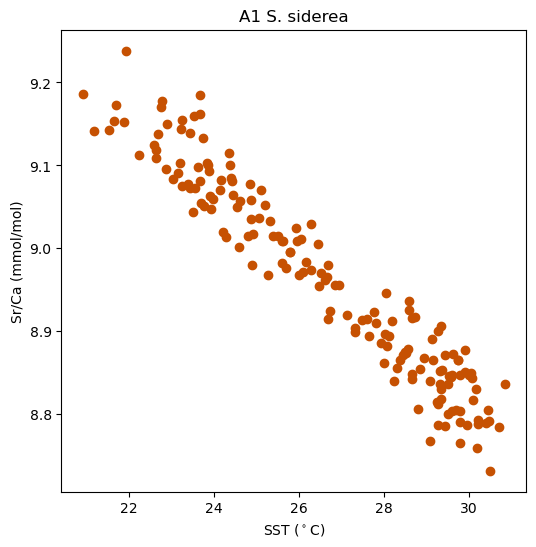

In [14]:
cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol)','Sand Key SST (ºC)']) #Remove NaNs

y = cleaned_df.iloc[:,1]
x = cleaned_df.iloc[:,12]

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(x,y,marker= 'o', color = sns.xkcd_rgb['dark orange'])
ax.set_title('A1 S. siderea')
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.show()

Let's fit a Bayesian linear regression to the *Siderastrea sidera* - core A1 data. In PyMC, the model specifications takes place with a `with` epxression, called a context manager. By default, PyMC uses a [NUTS sampler](http://arxiv.org/abs/1111.4246) to fit the model, resulting in a trace of samples representing the posterior distributions of the parameters.

In the Bayesian framework, we first need to define prior distributions for the slope and intercept as well as the expected error of the model. Let's first assume that we don't know much about the relationship between Sr/Ca and temperature, except for the fact that it is negative (which we infer from a simple plot from our [data exploration](DataExploration.ipynb) work). To represent this poor prior knowledge, we can use a uniform distribution with an upper limit of 0. The plot also suggests a total Sr/Ca change of -0.5mmol/mol for 10°C of temperature, which gives an average slope of -0.05 mmol/mol/°C. Let's double this for the lower limit of the uniform distribution. 

To set the prior for the intercept, we can also use a non-informative, uniform prior. The same figure places the y-intercept around 10mmol/mol. Let's use a range between 5 and 15 as boundaries for the uniform distribution:

In [19]:
with Model() as model:
    
    # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
    slope = Uniform('Slope',lower=-0.1, upper=0)
    intercept = Uniform('Intercept',lower=5, upper=15)
    sigma = HalfCauchy("sigma", beta=10)
    
    #Define the likelihood 
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    #inference with 3000 samples, tuning on the first 1000 with 4 chains   
    idata = sample(draws=3000, chains = 4, tune = 1000)

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:12

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 12 seconds.


### Analyzing the model

Bayesian inference gives us a posterior distribution of plausible parameters. Let's plot the posterior distribution of our parameters and the individual samples we drew:

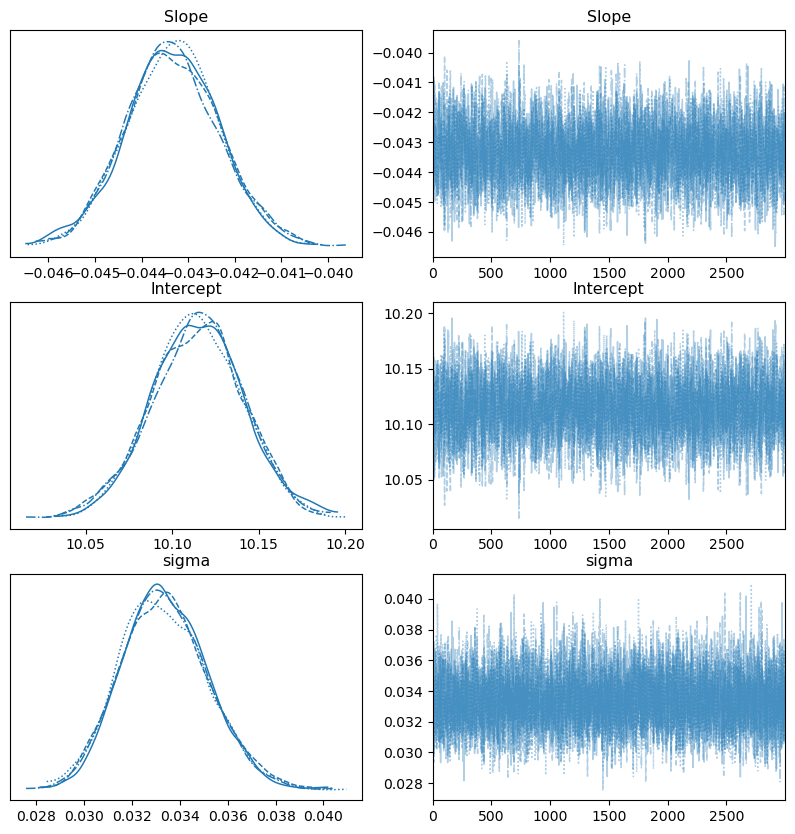

In [18]:
az.plot_trace(idata, figsize=(10,10))
plt.show()

The left panel shows the posterior distributions for the slope, intercept and the standard deviation of the regression residuals (`sigma`). The right panel shows the sampling chain for the posterior (i.e. the actual sequence of draws from the posterio). The sampling chains for the three parameters seem homogeneous and stationary (no large drifts and other noticeable patterns). This is good news, and likely means that the algorithm has likely converged towards the answer.

Now let's have a closer look at the mean of the distributions and associated standard deviations:

In [35]:
print("Slope Mean:", f"{idata.posterior['Slope'].mean():.3f}")
print("Slope Standard Deviation:", f"{idata.posterior['Slope'].std():.3f}")
print("Intercept Mean:", f"{idata.posterior['Intercept'].mean():.3f}")
print("Intercept Standard Deviation:", f"{idata.posterior['Intercept'].std():.3f}")

Slope Mean: -0.043
Slope Standard Deviation: 0.001
Intercept Mean: 10.115
Intercept Standard Deviation: 0.025


The statistics of the distribution are the same as the point estimates obtained from the linear regression [performed in the previous chapter](Calibration.ipynb). This is to be expected. However, a big advantage of Bayesian regression is that we now have joint probability distributions for possible regression lines. Let's plot a few of them:

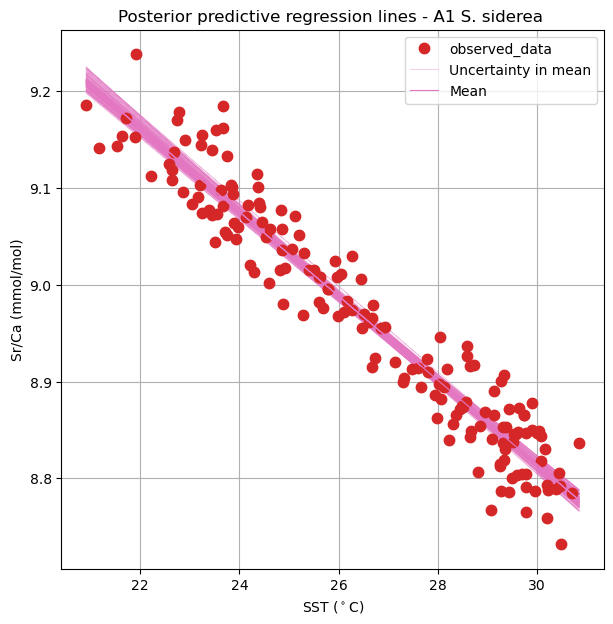

In [52]:
idata.posterior["y_model"] = idata.posterior["Intercept"] + idata.posterior["Slope"] * xr.DataArray(x)

_, ax = plt.subplots(figsize=(7, 7))
az.plot_lm(idata=idata, y="y", num_samples=100, axes=ax, x=x,y_model="y_model")
ax.set_title("Posterior predictive regression lines - A1 S. siderea ")
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.legend(loc='upper right');

We can see that the lines are very close to each other around the centroid of the dataset (SST near 26°C, Sr/Ca near 9 mmol/mol) but fan out near the edges of the range -- as predicted by theory. 


## *Montastraea faveolata*

Let's redo the calculation for *Montastraea faveolata* Sr/Ca using similar priors. 
### Estimating the model

For ease, let's store the data into two variables `x` and `y`. `y` contains the Sr/Ca data and `x` is the Sand Key data. 

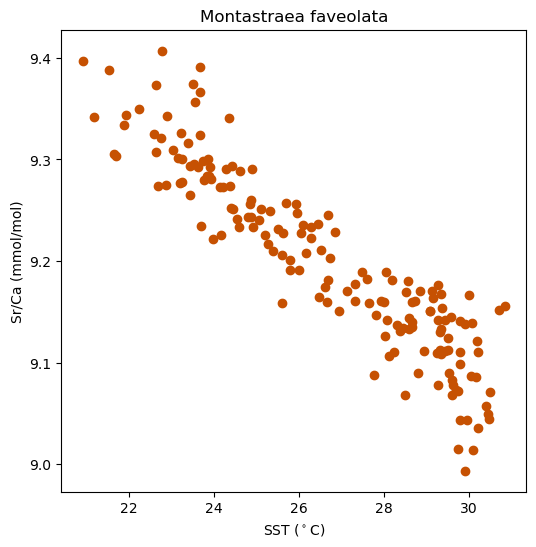

In [55]:
cleaned_df = df.dropna(subset=['Mean Sr/Ca (mmol/mol).2','Sand Key SST (ºC)']) #Remove NaNs

y = cleaned_df.iloc[:,7]
x = cleaned_df.iloc[:,12]

fig, ax = plt.subplots(1,1, figsize=(6,6))

ax.scatter(x,y,marker= 'o', color = sns.xkcd_rgb['dark orange'])
ax.set_title('Montastraea faveolata')
ax.set_xlabel('SST ($^\circ$C)')
ax.set_ylabel('Sr/Ca (mmol/mol)')
plt.show()

Let's fit our model:

In [59]:
with Model() as model:
    
    # Prior is a uniform distribution over the -1 to 0 interval for the slope and 0 to 50 for intercept
    slope = Uniform('Slope',lower=-0.1, upper=0)
    intercept = Uniform('Intercept',lower=5, upper=15)
    sigma = HalfCauchy("sigma", beta=10)
    
    #Define the likelihood 
    likelihood = Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)
    #inference with 5000 samples, tuning on the first 1000 with 4 chains   
    idata = sample(draws=5000, chains = 4, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Slope, Intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 12 seconds.


### Analyzing the model

Let's plot the posterior distribution and calculate the statistis:

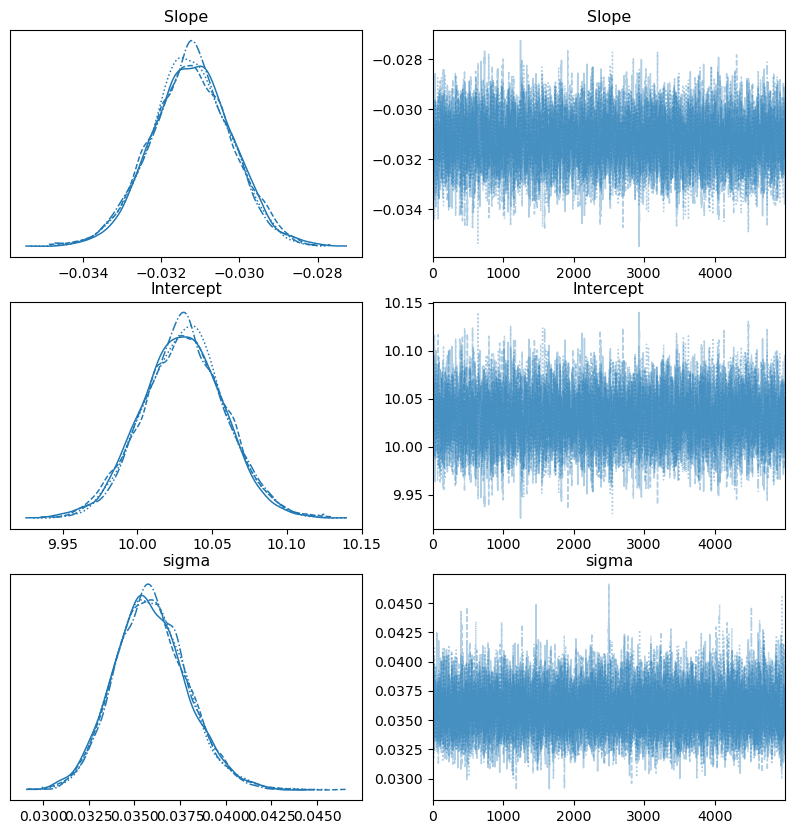

In [60]:
az.plot_trace(idata, figsize=(10,10))
plt.show()

In [61]:
print("Slope Mean:", f"{idata.posterior['Slope'].mean():.3f}")
print("Slope Standard Deviation:", f"{idata.posterior['Slope'].std():.3f}")
print("Intercept Mean:", f"{idata.posterior['Intercept'].mean():.3f}")
print("Intercept Standard Deviation:", f"{idata.posterior['Intercept'].std():.3f}")

Slope Mean: -0.031
Slope Standard Deviation: 0.001
Intercept Mean: 10.031
Intercept Standard Deviation: 0.028


## References

DeLong, K.L., J.A. Flannery, C.R. Maupin, R.Z. Poore, and T.M. Quinn. 2011. A coral Sr/Ca calibration and replication study of two massive corals from the Gulf of Mexico. Palaeogeography, Palaeoclimatology, Palaeoecology, 307(1-4), 117-128. doi: 10.1016/j.palaeo.2011.05.005